<a href="https://colab.research.google.com/github/vocaliodmiku/ASR/blob/master/nasal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Excitation Source and Vocal Tract System Based Acoustic Features for Detection of Nasals in Continuous Speech](https://www.isca-speech.org/archive/Interspeech_2019/pdfs/2785.pdf)  
notebook存在下载数据集的代码，建议在colab中运行或者剥离主要算法指定自己的数据。

1. 授权Colab访问Google Drive  
非必要，除非你的数据放在云端硬盘上，为了方便我放了几条中文语音在云盘上。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import scipy.io.wavfile as wav#
import matplotlib.pyplot as plt
import os
from scipy.fftpack import fft
from scipy.signal import hilbert
from tqdm import tqdm
import logging
logging.basicConfig(level = logging.INFO,format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
import IPython

2. 原论文使用TIMIT数据集，这里下载并处理  

In [0]:
!pip install python_speech_features sphfile
!apt install sox

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5889 sha256=ee95dd05f2eb4c9123631d19fdac5f080cd1e3f5689b9c454c33a9a97c6da8d2
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
  Created wheel for sphfile: filename=sphfile-1.0.1-cp36-none-any.whl size=3720 sha256=a481b76b2f080efd245439753cb8fd0c886cb17f6c7340551cf699ccaa237546
  Stored in directory: /root/.cache/pip/wheels/73/a8/71/e339da6bfe707de7c5d1631750b163f36b6ec14efe48f97ec1
Successfully built python-speech-features sphfile
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packa

* Note：你需要手动结束种子任务，当Downloading Completed后就可以终止这个代码框，并在运行之后的代码框。

In [0]:
import os
if not os.path.exists("timit"):
    get_ipython().system("apt-get install ctorrent")  ## for Ubuntu/Debian
    get_ipython().system("wget http://academictorrents.com/download/34e2b78745138186976cbc27939b1b34d18bd5b3.torrent")
    get_ipython().system("ctorrent 34e2b78745138186976cbc27939b1b34d18bd5b3.torrent")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  ctorrent
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 100 kB of archives.
After this operation, 230 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 ctorrent amd64 1.3.4.dnh3.3.2-5 [100 kB]
Fetched 100 kB in 1s (118 kB/s)
Selecting previously unselected package ctorrent.
(Reading database ... 135073 files and directories currently installed.)
Preparing to unpack .../ctorrent_1.3.4.dnh3.3.2-5_amd64.deb ...
Unpacking ctorrent (1.3.4.dnh3.3.2-5) ...
Setting up ctorrent (1.3.4.dnh3.3.2-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
--2019-12-17 16:01:47--  http://academictorrents.com/download/34e2b78745138186976cbc27939

KeyboardInterrupt: ignored

In [0]:
!unzip TIMIT.zip > /dev/null
!cp -rp data/lisa/data/timit/raw/TIMIT timit
!rm -rf data

3. 将TIMIT数据集转为wav格式

In [0]:
from sphfile import SPHFile
import glob
import os

def WAV2wav(path):
    """
    将所有WAV文件处理为wav文件，并删除原有WAV文件。
    """
    path = path + '/*/*/*/*.WAV'
    sph_files = glob.glob(path)
    print(len(sph_files),"train/test utterences")
    for i in sph_files:
        sph = SPHFile(i)
        sph.write_wav(filename=i.replace(".WAV",".wav"))
        os.remove(i)
    print("Completed")
    
WAV2wav("/content/timit")

6300 train/test utterences
Completed


4. 作图函数，实现论文figure 1的效果，需要标注信息

In [0]:
def plot_signal(ax, timeset,height,phn_path):
    [start, end] = timeset
    color = 'k'
    time_start = None
    time_end = None
    with open(phn_path, 'r') as f:
        lines = f.readlines()
        lines = lines[start:end]
        index = 0
        for line in lines:
            st, ed, ph = line.split(' ')
            st, ed = int(st), int(ed)
            # 起始音素
            if index == 0:
                time_start = st
                ax.annotate('', xy=(0,height), 
                            xytext=(0,height-0.5),
                            weight='book',color='r',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3",
                                            linewidth=1,
                                            color=color))
                ax.text((st+ed)/2-time_start, height-0.25, ph)
            # 终止音素
            elif index == (end-start)-1:
                time_end = ed
                ax.annotate('', xy=(st-time_start,height), 
                            xytext=(st-time_start,height-0.5),
                            weight='book',color='r',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3",
                                            linewidth=1,
                                            color=color))
                ax.text((st+ed)/2-time_start, height-0.25, ph)
                ax.annotate('', xy=(ed-time_start,height), 
                            xytext=(ed-time_start,height-0.5),
                            weight='book',color='r',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3",
                                            linewidth=1,
                                            color=color))
            # 中间音素
            else:
                ax.annotate('', xy=(st-time_start,height), 
                            xytext=(st-time_start,height-0.5),
                            weight='book',
                            color='r',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3",
                                            linewidth=1,
                                            color=color))
                ax.text((st+ed)/2-time_start, height-0.25, ph)
            index +=1
            
    return [time_start, time_end]

5. 读取音频，注释中为中文语音id及其文本信息。

In [0]:
# 17 ta xing shen me
# 18 ta bu shiii lao shiii ta shiii xue sheng
# 23 uo shiii zhang lao shiii de xue sheng
# 184 zhu ni sheng ri kuai le 
# 185 zhu ni shen ti jian kang 
# wavpath = 'drive/My Drive/Colab Notebooks/CF010001_184.wav'
wavpath = '/content/timit/TRAIN/DR1/FCJF0/SX307.wav'
phnpath = 'timit/TRAIN/DR1/FCJF0/SX307.PHN'
timit = True

fs, wavsignal_source = wav.read(wavpath)
IPython.display.Audio(wavpath)

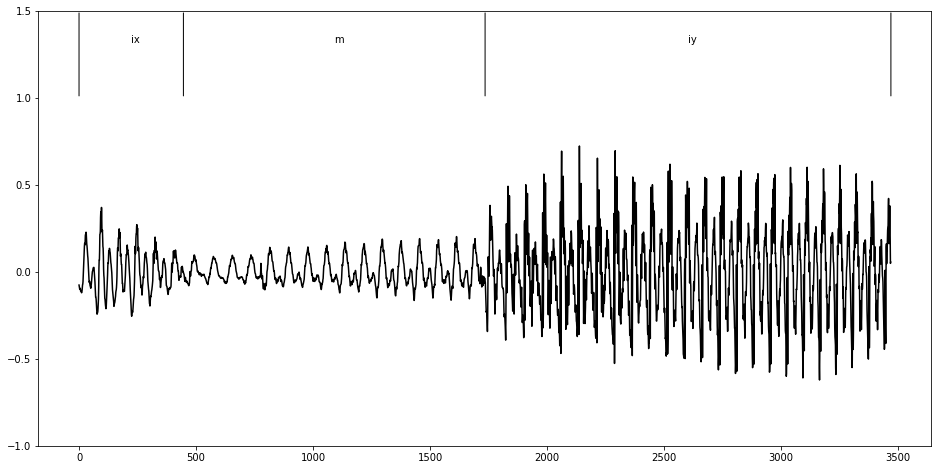

In [0]:
st = 2 # 10 # when timit is true
ed = 5 # 15 # when timit is true

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
plot_wav = wavsignal_source/wavsignal_source.max()
if timit:
    ax.set_ylim(-1, 1.5)
    [time_st, time_ed] = plot_signal(ax,[st,ed],1.5,phnpath)
    ax.plot(plot_wav[time_st:time_ed] ,'k')
else:
    ax.plot(plot_wav[st:ed] ,'k')

#plt.axis([8000, 18000, -1, 1])
plt.savefig('filename.svg',format='svg')
plt.show()

if timit:   
    wavsignal = wavsignal_source[time_st:time_ed]
else:
    wavsignal = wavsignal_source[st:ed]

In [0]:
"""
https://github.com/mgurunathreddy/Adaptive-ZFF-F0-Extraction
https://github.com/RedHenLab/Audio/blob/76107c86054845a0e9d8517f36948c03d2ae34ff/GSoC2015/Breath_Detection/breath_detection_codes/zfsig_mod.m
[1] K. S. R. Murty and B. Yegnanarayana, “Epoch extraction from speech signals,” 
IEEE Transactions on Audio, Speech, and Language Processing, vol. 16, no. 8, pp. 1602–1613, 2008.
"""
import numpy as np
#import waveio as io
#import matplotlib.pyplot as plt


def remTrend(sig, winSize):
    # (Eq. 17)
    # Added on 2-May-2015
    if np.isnan(winSize):
        winSize = 250 # choose by default 4ms window length
#        print "The default window size is choosen: " + '\t' +  str(winSize) + " samples"
             
    window = np.ones(winSize)
    
    rm = np.convolve(sig, window)
    rm = rm[winSize//2:np.shape(rm)[0] - (winSize//2)+1] 
    
    norm = np.convolve(np.ones(np.shape(sig)[0]), window)
    norm = norm[winSize//2:np.shape(norm)[0]-(winSize//2)+1]
    
    rm = rm/norm # Check whether this is doing proper division
    out = sig - rm
    return out


def zeroFreqFilt(wav, fs, winLen):
    dwav = np.diff(wav)
    dwav = np.append(dwav, dwav[-1])
    dwav = dwav/np.max(np.abs(dwav))
    N = np.shape(dwav)[0]
    # filtering at zero frequency
    zfSig = np.cumsum(np.cumsum(np.cumsum(np.cumsum(dwav))))
        
    winLen = int(np.round((winLen*fs)/1000.0))
    # Remove the trend 
    zfSig = remTrend(zfSig, winLen)
    zfSig = remTrend(zfSig, winLen)
    zfSig = remTrend(zfSig, winLen)
    zfSig[N-winLen*2:N] = 0
    zfSig[0:winLen*2] = 0
    return zfSig

def zff(wav, fs, winLen):
#    print "Window length is not calculated using autocor in zff.py"
    zf = zeroFreqFilt(wav, fs, winLen)
    # plt.figure(10)
    # plt.plot(zf[5000:10000])
    zf1 = np.copy(zf)
    zf[zf>0] = 1
    zf[zf<0] = -1
    gci = np.where(np.diff(zf) == 2)[0]
    # slope of ZFF signal around epochs
    es = np.abs(zf1[gci+1]-zf1[gci-1])
    T0 = np.diff(gci)
    T0 = T0/float(fs)
    f0 = 1.0/T0
    f0 = np.append(f0, f0[-1])
    # energy
    energy_gci = np.zeros(gci.shape)
    # 1.5 msec on each side of epoch
    windows = int(fs*0.001*1.5)
    index = 0
    for i in gci:
        energy_gci[index] = np.sum(zf1[i-windows:i+windows]**2)
        index +=1
    return zf1, gci, es, f0, energy_gci

In [0]:
# inputFile = 'out_female.wav'
# (fs, x) = io.wavread(inputFile)
wavsignal = np.array(wavsignal, np.float64)

# zf      - zero-frequency resonator signal
# gci     - glottal closure instants
# es      - excitation strength at GCIs
# f0      - pitch frequency
[zf, gci, es, f0, eg] = zff(wavsignal, fs, 4)

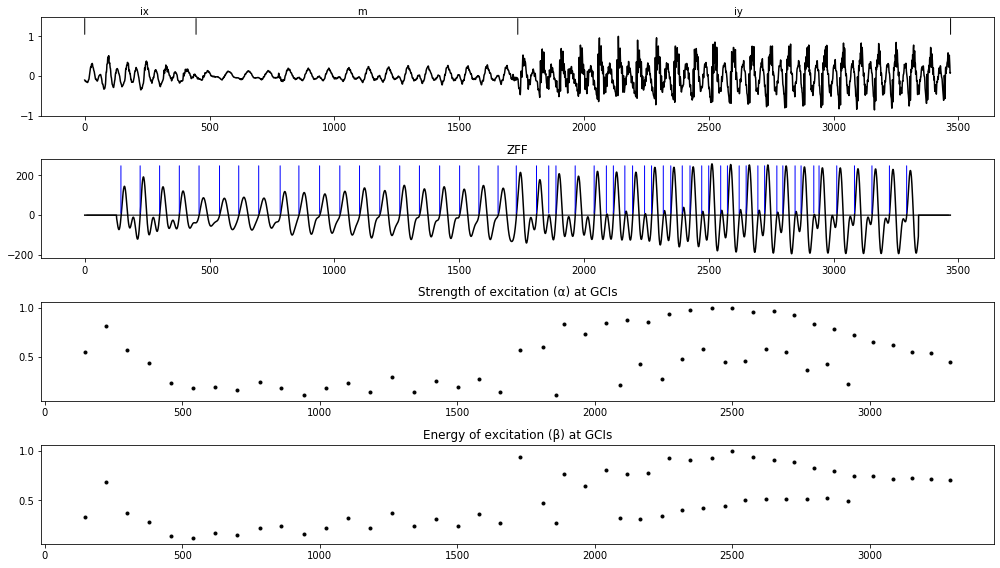

In [0]:
#@title
s = 9
color='k'
# figure
fig = plt.figure(figsize=(14,8))
# ax0
if timit:
    ax0 = fig.add_subplot(411)
    plot_wav = wavsignal_source[time_st:time_ed]
    plot_wav = plot_wav/plot_wav.max()
    ax0.set_ylim(-1, 1.5)
    plot_signal(ax0,[st,ed],1.5,phnpath)
    ax0.plot(plot_wav,'k')
else:
    ax0 = fig.add_subplot(411)
    ax0.plot(plot_wav[st:ed],'k')
# ax1 
ax1 = fig.add_subplot(412)
ax1.set_title('ZFF')
ax1.plot(zf,'k')
i = 1
for i in gci:
        ax1.annotate('', xy=(i,0), xytext=(i,zf.max()),weight='book',
             arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3",
                            linewidth=1,
                            color='b'))
ax1.annotate('', xy=(0,0), xytext=(len(zf),0),weight='book',
             arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3",
                             linewidth=1))
# ax2
ax2 = fig.add_subplot(413)
ax2.set_title('Strength of excitation (α) at GCIs')
ax2.scatter(gci, es/es.max(), s=s, color=color)

# ax3
ax3 = fig.add_subplot(414)
ax3.set_title('Energy of excitation (β) at GCIs')
ax3.scatter(gci, eg/eg.max(), s=s, color=color)

plt.savefig('filename.svg',format='svg')
plt.tight_layout()

In [0]:
def w1(x,fs,N=None):
# weight by 1/(4*sin^2(w)) , assume N=20 ms; eg: 320 at 16kHz.
    n1ms=int(np.round(fs/1000))
    if N is None:
        N=5*n1ms

    if len(x) > N:
        x = x[:N]
    elif len(x) < N:
        x_temp = np.zeros(N)
        x_temp[:len(x)] = x
        x = x_temp

    n=np.pi*np.arange(N)/N
    # avoid // zero
    n[0]= np.pi
    w=1./(2*(1-np.cos(n)))
    w[0]=0
    xw=w*x
    return xw,w
def w2(x,fs,N=None):
    n1ms=int(np.round(fs/1000))
    if N is None:
        N=5*n1ms

    if len(x) > N:
        x = x[:N]
    elif len(x) < N:
        x_temp = np.zeros(N)
        x_temp[:len(x)] = x
        x = x_temp

    n=np.pi*np.arange(N)/N
    w=2*(1+np.cos(n))
    xw=w*x
    return xw,w
def w0(x,fs,N=None):

    n1ms=int(np.round(fs/1000))
    if N is None:
        N=5*n1ms

    if len(x) > N:
        x = x[:N]
    elif len(x) < N:
        x_temp = np.zeros(N)
        x_temp[:len(x)] = x
        x = x_temp
    # https://www.isca-speech.org/archive/Interspeech_2019/pdfs/2785.pdf e.q (1)
    n=np.pi*np.arange(N)/N
    w=0.125/(np.sin(n)**4)
    xw=w*x
    return xw,w

def group_delay_func(x,Nfft=None,fs=8000,m=0.5):
    """
    https://github.com/RedHenLab/Audio/blob/76107c86054845a0e9d8517f36948c03d2ae34ff
    /GSoC2015/Breath_Detection/breath_detection_codes/gdelay1d.m
    """
    mag= [];
    NARGEXP = 4
    if Nfft is None:
        Nfft = len(x)

    # f = [0:Nfft-1]*fs/Nfft;
    # Check for zero signal
    if(np.sum(x**2)==0):
        gd = np.zeros(Nfft,1)
        ngd = np.zeros(Nfft,1)
        mgd = np.zeros(Nfft,1)
        return ngd

    X = np.fft.fft(x,Nfft)
    Xr = np.real(X)
    Xi = np.imag(X)
    Xm = np.abs(X)
    if(sum(Xm==0)>0):
        # https://blog.csdn.net/weixin_41713230/article/details/81283813
        print('Magnitude spectrum is zero at some frequencies. Fixing divide by zero error')
        Xm[Xm==0]=min(Xm[Xm!=0])

    n = np.arange(len(x))
    y = n*x
    Y = np.fft.fft(y,Nfft)
    Yr = np.real(Y)
    Yi = np.imag(Y)

    NGD = Xr*Yr + Xi*Yi
    return NGD

def ZTW(wav, fs, nwin):
    nfft = 1024
    temp = wav
    nwin = int(nwin)
    # TODO: HNGDM here is different from matplot code.(transposed for easily understanding)
    HNGDM = np.zeros((len(temp)-nwin, nfft//2))
    logger.info("Caculating HNGDM features...\n")
    for i in tqdm(range(len(temp)-nwin)):
        y = temp[i:i+nwin]
        yw, _ = w2(y,fs,nwin)
        yw, _ = w1(yw,fs,nwin)
        yw, _ = w1(yw,fs,nwin)
        # yw, _ = w0(y,fs,nwin)
        NGD = group_delay_func(yw,nfft,fs,0.5)
        NGD = np.concatenate((NGD,NGD,NGD),axis=0)
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
        HNGD = np.abs(hilbert(np.diff(np.diff(np.diff(NGD)))))
        nfftby2=int(np.floor(nfft/2))
        HNGD=HNGD[nfft-4+1:nfft-4+nfftby2+1]
        HNGD=HNGD[0:512]
        HNGDM[i]=HNGD[0:512]
    return HNGDM

def find2PEAKlocations(data,level):
    m, n = data.shape 
    pos1 = np.zeros((m,1))
    pos3 = np.zeros((m,1))
    str1 = np.zeros((m,1))
    str3 = np.zeros((m,1))
    logger.info("Caculating DRF features...\n")
    for index in tqdm(range(m)):
        data1 = data[index]
        data_diff = np.diff(data1)         # data_diff.shape == (511,)
        #data_diff_shift = circshift(data_diff,[1 1]);
        data_diff_shift = np.roll(data_diff, 1, axis=0)
        data_multiply = data_diff*data_diff_shift
        data_multiply[0]=0
        data_multiply = np.append(data_multiply, 0) # data_multiply.shape == (512,)
        place = data_multiply<0
        temp = np.zeros(data_multiply.shape)
        temp[place] = data1[place]
        # [Y,U]=max(A)：返回行向量Y和U，Y向量记录A的每列的最大值，U向量记录每列最大值的行号。
        f1, f2 = temp.max(0), temp.argmax(0)
        str1[index]=f1
        pos1[index]=f2
        # the 1st & 2nd DRF's
        if level==2:
            temp[f2] = 0
            f3, f4= temp.max(0), temp.argmax(0)
            pos3[index] = f4
            str3[index] = f3

    if level==2:
        pos1 = [pos1, pos3]
        str1 = [str1, str3]

    return str1, pos1

def HNGDandMSSPs(s,fs,winlen):
    pass

def DRFandDRS(pos1,str1,gci,wav,fs):
    ngci = len(gci)
    # hngdM = newZTL(wav,fs,nwin)
    # str1, pos1 = find2PEAKlocations(hngdM,2)
    pos1, pos2 = pos1
    str1, str2 = str1
    drf_1 = pos1 * fs/(2 * 512)
    drf_1 = np.append(pos1, np.arange(len(wav)-len(pos1)))
    drf = np.zeros((ngci,1))
    
    str_1 = np.append(str1, np.arange(len(wav)-len(str1)))
    str_2 = np.append(str2, np.arange(len(wav)-len(str2)))
    str1 = np.zeros((ngci,1))
    str2 = np.zeros((ngci,1))
    
    for k in range(ngci):
        if gci[k] <= 16:
            pos_part = drf_1[0 : gci[k] + 16]
            drf[k] = np.sum(pos_part)/(gci[k] + 16)
            str1_part = str_1[0 : gci[k] + 16]
            str2_part = str_2[0 : gci[k] + 16]
            str1[k] = np.sum(str1_part)
            str2[k] = np.sum(str2_part)
            
        else:
            pos_part = drf_1[gci[k] - 16 : gci[k] + 16]
            drf[k] = np.sum(pos_part)/33
            str1_part = str_1[gci[k] - 16 : gci[k] + 16]
            str2_part = str_2[gci[k] - 16 : gci[k] + 16]
            str1[k] = np.sum(str1_part)
            str2[k] = np.sum(str2_part)

    drf_gci = np.squeeze(drf)
    drs_gci = np.squeeze(str1/(abs(str1)).max())
    # x:gci, y:drf/drs
    dgci = np.diff(gci)
    ddrf_gci = np.diff(drf_gci)
    ddrs_gci = np.diff(drs_gci)

    slopes_drf_gci = ddrf_gci / dgci
    slpoes_drs_gci = ddrs_gci / dgci

    return drf_gci, drs_gci, slopes_drf_gci, slpoes_drs_gci # gamma

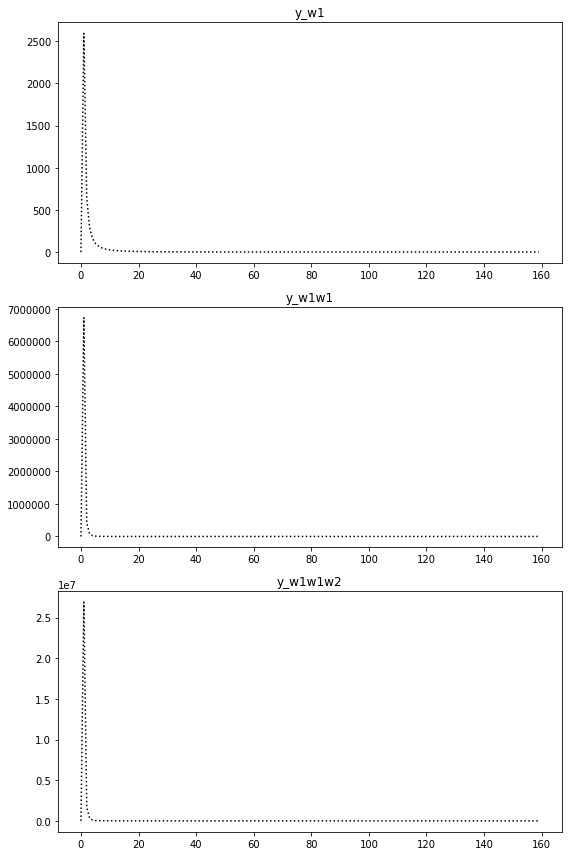

In [0]:
nwin = int(0.01*fs)
x = np.ones(nwin)

x_w1,_ = w1(x,fs,N=nwin)
x_w1w1,_ = w1(x_w1,fs,N=nwin)
x_w1w1w2,_ = w2(x_w1w1,fs,N=nwin)

plt.close('all')
fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(311)
ax1.set_title('y_w1')
ax1.plot(x_w1, ls=':',color='k')

ax2 = fig.add_subplot(312)
ax2.set_title('y_w1w1')
ax2.plot(x_w1w1, ls=':',color='k')

ax3 = fig.add_subplot(313)
ax3.set_title('y_w1w1w2')
ax3.plot(x_w1w1w2, ls=':',color='k')
plt.tight_layout()

In [0]:
HNGDM = ZTW(wavsignal, fs, fs*0.01)

2019-12-17 16:31:25,862 - __main__ - INFO - Caculating HNGDM features...

100%|██████████| 3309/3309 [00:09<00:00, 332.15it/s]


In [0]:
str1, pos1 = find2PEAKlocations(HNGDM,2)

2019-12-17 16:31:35,836 - __main__ - INFO - Caculating DRF features...

100%|██████████| 3309/3309 [00:00<00:00, 12410.67it/s]


In [0]:
drf_gci, drs_gci, slopes_drf_gci, slopes_drs_gci = DRFandDRS(pos1,str1,gci,wavsignal,fs)

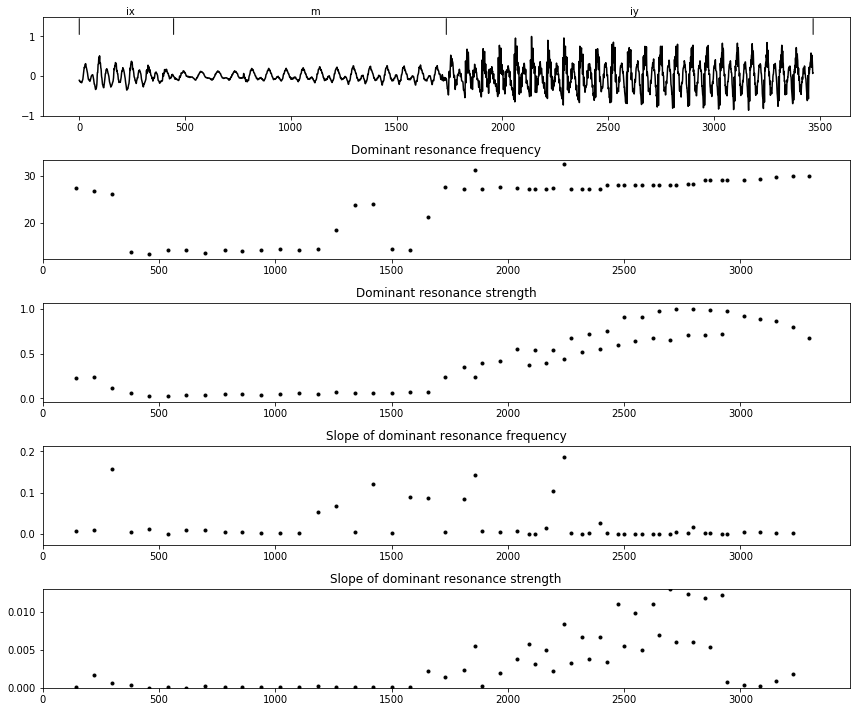

In [0]:
#@title
s = 9
color='k'
# figure
fig = plt.figure(figsize=(14,8))
# ax0
if timit:
    ax0 = fig.add_subplot(411)
    plot_wav = wavsignal_source[time_st:time_ed]
    plot_wav = plot_wav/plot_wav.max()
    ax0.set_ylim(-1, 1.5)
    plot_signal(ax0,[st,ed],1.5,phnpath)
    ax0.plot(plot_wav,'k')
else:
    ax0 = fig.add_subplot(411)
    ax0.plot(plot_wav[st:ed],'k')
# ax1 
ax1 = fig.add_subplot(412)
ax1.set_title('ZFF')
ax1.plot(zf,'k')
i = 1
for i in gci:
        ax1.annotate('', xy=(i,0), xytext=(i,zf.max()),weight='book',
             arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3",
                            linewidth=1,
                            color='b'))
ax1.annotate('', xy=(0,0), xytext=(len(zf),0),weight='book',
             arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3",
                             linewidth=1))
# ax2
ax2 = fig.add_subplot(413)
ax2.set_title('Strength of excitation (α) at GCIs')
ax2.scatter(gci, es/es.max(), s=s, color=color)

# ax3
ax3 = fig.add_subplot(414)
ax3.set_title('Energy of excitation (β) at GCIs')
ax3.scatter(gci, eg/eg.max(), s=s, color=color)

plt.savefig('filename.svg',format='svg')
plt.tight_layout()

s = 9
# color='k'

plt.close('all')
fig = plt.figure(figsize=(12,10))

ax0 = fig.add_subplot(511)
if timit:
    plot_wav = wavsignal_source[time_st:time_ed]
    plot_wav = plot_wav/plot_wav.max()
    ax0.set_ylim(-1, 1.5)
    plot_signal(ax0,[st,ed],1.5,phnpath)
    ax0.plot(plot_wav ,'k')
else:
    ax0.plot(plot_wav[st:ed],'k')
    time_ed, time_st = ed, st
ax1 = fig.add_subplot(512)
ax1.set_title('Dominant resonance frequency')
ax1.set_xlim(0,time_ed-time_st)
ax1.scatter(gci,drf_gci,s=s,color=color)

ax2 = fig.add_subplot(513)
ax2.set_title('Dominant resonance strength')
ax2.set_xlim(0,time_ed-time_st)
ax2.scatter(gci,drs_gci,s=s,color=color)

ax3 = fig.add_subplot(514)
ax3.set_title('Slope of dominant resonance frequency')
ax3.set_xlim(0,time_ed-time_st)
ax3.scatter(gci[:-1],np.abs(slopes_drf_gci),s=s,color=color)

ax4 = fig.add_subplot(515)
ax4.set_title('Slope of dominant resonance strength')
ax4.set_xlim(0,time_ed-time_st)
ax4.set_ylim(0,slopes_drs_gci.max())
ax4.scatter(gci[:-1],abs(slopes_drs_gci),s=s,color=color)


plt.tight_layout()


In [0]:
# 0.epoch location
gci = gci

# 1.Extraction of excitation source based acoustic features
# ZFF (zero frequency filtered)
zff = zf
# 1.1 Strength of excitation (α)
alpha = es
# 1.2 Energy of excitation (β)
beta = eg

# 2.Extraction of vocal tract system based acoustic features
# ZTW (Zero-time windowing)
hngd = HNGDM
# 2.1 Dominant resonance frequency (DRF)
drf = drf_gci
# 2.1 Dominant resonance strength (γ)
drs = drs_gci
# 2.3 Slope of dominant resonance frequency (Fsl)
ddrf = slopes_drf_gci
# 2.4 Slope of dominant resonance strength (γsl)
ddrs =  slopes_drs_gci

# 3.combination of excitation source and vocal tract system features 
# 3.1 (α) x DRS
v1 = alpha * drs
# 3.2 (β) x DRS
v2 = beta * drs

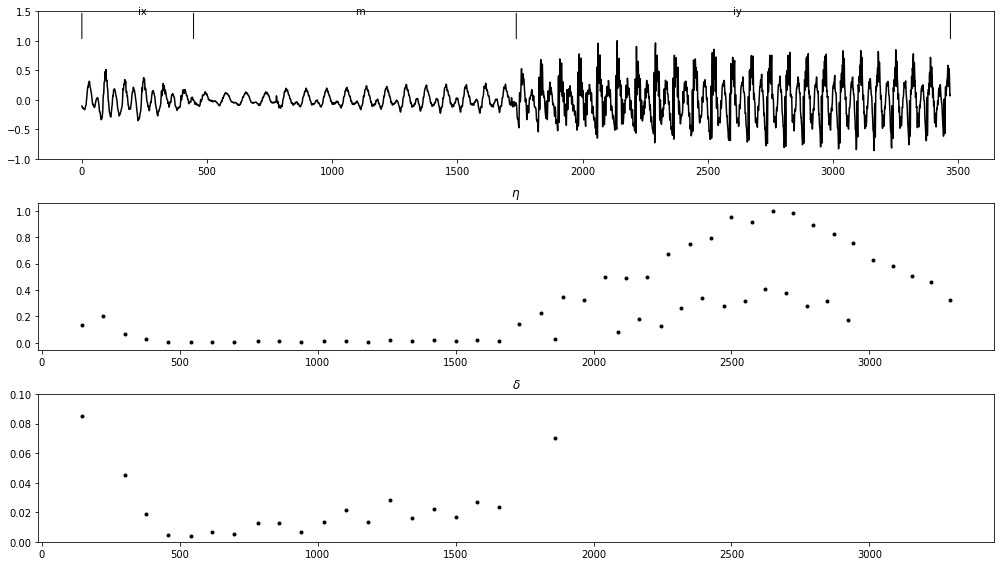

In [0]:
#@title
s = 9
color='k'
# figure
fig = plt.figure(figsize=(14,8))
# ax1
if timit:
    ax0 = fig.add_subplot(311)
    plot_wav = wavsignal_source[time_st:time_ed]
    plot_wav = plot_wav/plot_wav.max()
    ax0.set_ylim(-1, 1.5)
    plot_signal(ax0,[st,ed],1.5,phnpath)
    ax0.plot(plot_wav,'k')
else:
    ax0 = fig.add_subplot(411)
    ax0.plot(plot_wav[st:ed],'k')
# ax2
ax2 = fig.add_subplot(312)
ax2.set_title('$\eta$')
ax2.scatter(gci,v1/v1.max(), s=s, color=color)
ax3.set_ylim(0, 0.1)
# ax3
ax3 = fig.add_subplot(313)
ax3.set_title('$\delta$')
ax3.set_ylim(0, 0.1)
ax3.scatter(gci, v2/v2.max(), s=s, color=color)

plt.savefig('filename.svg',format='svg')
plt.tight_layout()

-1. some code to ensure what i've done is right

In [0]:
y2 = [.16, .07, .03, .01, .008, .003, .0008, .0003, .00007, .00002 ]
FFTData = np.fft.fft(y2,10)
xr = np.real(FFTData)
xi = np.imag(FFTData)
print(xr)
print(xi)
## https://www.tutorialspoint.com/execute_matlab_online.php
## matlab version
# y2 = [.16 .07 .03 .01 .008 .003 .0008 .0003 .00007 .00002 ];
# FFTData = fft(y2,10);
# xr = real(FFTData)
# xi = imag(FFTData)
# disp(xr(:));
# disp(xi(:));

[0.28219    0.21263729 0.1546967  0.12208771 0.1117083  0.11555
 0.1117083  0.12208771 0.1546967  0.21263729]
[ 0.00000000e+00 -8.30556355e-02 -7.15982237e-02 -5.01086124e-02
 -1.76612848e-02  6.93889390e-18  1.76612848e-02  5.01086124e-02
  7.15982237e-02  8.30556355e-02]


In [0]:
Xm = np.array([[1,2,2,0],
               [0,0,2,3],
               [2,0,0,7]])
Xm[Xm==0]=min(Xm[Xm!=0])
Xm

array([[1, 2, 2, 1],
       [1, 1, 2, 3],
       [2, 1, 1, 7]])

In [0]:
## matlab verion
# ngd = Xr.*Yr + Xi.*Yi;
## numpy version
#ngd = Xr*Yr + Xi*Yi
## matlab verion
# x1 = [1 2 3 4 5 6];
# x2 = [1 2 3 4 5 6];
# x = x1./x2;
# disp(x(:));
# y = x1.^2
# disp(y(:));
## numpy version
x1 = np.array([1,2,3,4,5,6])
x2 = np.array([1,2,3,4,5,6])
x = x1/x2
x

array([1., 1., 1., 1., 1., 1.])

In [0]:
x1 = np.zeros((3,6))
x2 = np.array([1,2,3,4,5,6])
x1[1] = x2
x1

array([[0., 0., 0., 0., 0., 0.],
       [1., 2., 3., 4., 5., 6.],
       [0., 0., 0., 0., 0., 0.]])

In [0]:
ngd = np.array([1,2,3,4,5,6])
# matlab 中为行拼接 https://www.cnblogs.com/hezhiyao/p/6824083.html
# ngd=[ngd(:);ngd(:);ngd(:)];
ngd = np.concatenate((ngd,ngd,ngd),axis=0)
ngd

array([1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6])

In [0]:
## https://www.mathworks.com/help/matlab/ref/circshift.html
# A = [1 2 0 0; 3 4 0 0; 0 0 0 0; 0 0 0 0]
# circshift(A, [1 1])

A = np.array([1, 2, 3, 4])
# np.roll(x, shift, axis)
A = np.roll(A, 1, axis=0)
A

array([4, 1, 2, 3])

In [0]:
# A = [1 2 0 0; 3 4 0 0; 0 0 0 0; 0 0 0 0];
# % [2 1; 4 3]:
# A(1)=0;
# A(end)=8;
# disp(A)
A = np.array([[1, 2, 0, 0], [3, 4, 0, 0], [0, 0, 0, 0],[0, 0, 0, 0]])
A[0,0] = 0
A[-1,-1] = 8

In [0]:
B = np.ones(A.shape)
place = A>0
B[place] = A[place]
B

array([[1., 2., 1., 1.],
       [3., 4., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 8.]])

In [0]:
# A = [1 2 0 0; 3 4 0 0; 0 0 3 0; 0 0 0 7];
# % [2 1; 4 3]:
# [f1 f2]=max(A);
# disp(f1)
# disp(f2)
A = np.array([1,2,0,0])
v,i = A.max(0),A.argmax(0)
v,i

(2, 1)

In [0]:
A = np.array([1,2,0,0])
np.append(A, 0)
A

array([1, 2, 0, 0])

In [0]:
A = np.array([[1, 2, 0, 0], [3, -4, 0, 0], [0, 0, 0, 0],[0, 0, 0, 0]])
mx = (abs(A)).max()
mx

4

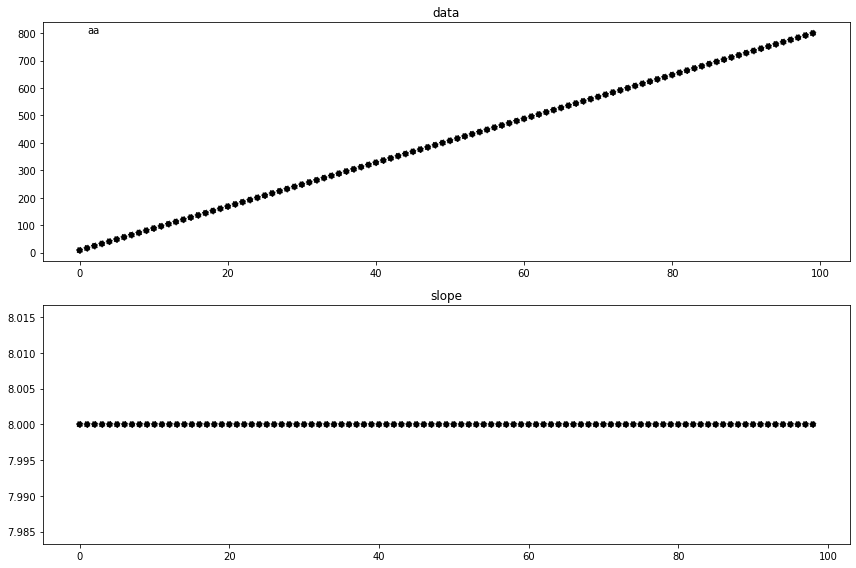

In [0]:
x = np.arange(100)
y = 8*x + 8

dx = np.diff(x)
dy = np.diff(y)
slopes = dy/dx
plt.close('all')
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1.set_title('data')
ax1.scatter(x,y, ls=':',color='k')
ax1.text(1, 800, 'aa')

ax1 = fig.add_subplot(212)
ax1.set_title('slope')
ax1.scatter(x[:-1],slopes, ls=':',color='k')
plt.tight_layout()

In [0]:
a = np.array([[1],[2],[3],[4]])
np.squeeze(a)

array([1, 2, 3, 4])

In [0]:
str = '123'
int(str)  

123

In [0]:
A = np.arange(10)
np.sum(A[1:4]**2) # 1 4 9

14